In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import umap
from quiroga import *
from sklearn.decomposition import PCA 
import hdbscan
from scipy.spatial.distance import cdist
import seaborn as sns
import pickle as pickle #5
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['svg.fonttype'] = 'none'
#plt.rcParams["font.family"] = "arial"

In [2]:
from scipy.signal import savgol_filter
from scipy.interpolate import PchipInterpolator
from scipy.signal.windows import tukey
import numpy as np


def denoiser(spikes, window_length=5, polyorder=3):
    """
    savgol_filter: Filter with a window length of 5 and a degree 3 polynomial.
        Use the defaults for all other parameters.


        Parameters
        ----------
        spikes : array, shape (n_spikes,n_sample_points)
            Array of all spikes you wish to denoise. Contains one spike per row.

        window_length : int
            The length of the filter window (i.e., the number of coefficients).

        polyorder : int
            The order of the polynomial used to fit the samples.
            `polyorder` must be less than `window_length`.

        Returns
        -------
        spikes_denoised : array, shape (n_spikes,n_sample_points)
            Array denoised all spikes after denoising. Contains one spike per row.


        TO DO: Implement more options for denoising filters.
    """
    spikes_denoised = savgol_filter(spikes, 5, 3)
    return spikes_denoised


def aligner(
    spikes,
    upsample_rate=8,
    alignment="tukey",
    window_length=24,
    min_sample=7,
    alpha=0.35,
    min_hs=11,
    max_hs=33,
    classic_center=11,
):
    n_sample_points = np.shape(spikes)[1]
    sample_points = np.arange(n_sample_points)
    dense_sample_points = np.arange(0, n_sample_points, 1 / upsample_rate)

    interpolator = PchipInterpolator(sample_points, spikes, axis=1)
    spikes_dense = interpolator(dense_sample_points)

    if alignment == "tukey":
        min_index = np.argmin(spikes_dense, axis=1)

        window = tukey(n_sample_points * upsample_rate, alpha=alpha)
        spikes_tukeyed = spikes_dense * window
        center = 12 * upsample_rate  # make this optional later

        spikes_aligned_dense = np.zeros(np.shape(spikes_tukeyed))

        # We apply circular shift to the spikes so that they are all aligned
        # to their respective minimums at the center point
        for count, row in enumerate(spikes_tukeyed):
            spikes_aligned_dense[count] = np.roll(row, -min_index[count] + center)
        # Note: It is very important that the downsampling is somehow
        #       Aligned to the minimum of each spike.
        downsample_points = np.arange(0, n_sample_points * upsample_rate, upsample_rate)

        spikes_aligned = spikes_aligned_dense[:, downsample_points]

    elif alignment == "classic":
        # WARNING: THIS IMPLEMENTATION IS CURRENTLY ONLY FOR QUIROGA DATA
        #          A Generalized version will come soon.
        # avg_min = int(np.argmin(spikes_dense, axis=1).mean())
        min_hs = 11 * upsample_rate
        max_hs = 33 * upsample_rate
        min_index = np.argmin(spikes_dense[:, min_hs:max_hs], axis=1) + min_hs
        # center = 15 * upsample_rate
        spikes_aligned_dense = np.full(spikes_dense.shape, np.nan)
        for i, row in enumerate(spikes_dense):
            r = row[min_index[i] - classic_center * upsample_rate :]
            spikes_aligned_dense[i, : len(r)] = r
        spikes_aligned_dense = spikes_aligned_dense[:, : window_length * upsample_rate]
        downsample_points = np.arange(0, window_length * upsample_rate, upsample_rate)
        spikes_aligned = spikes_aligned_dense[:, downsample_points]

    return spikes_aligned


In [3]:
def f_scorer(precision, recall):
    return (2 * precision * recall) / (precision + recall)

def dims(embedding, mask, d=3):
    if d == 3:
        return (embedding[mask, 0], embedding[mask, 1], embedding[mask, 2])
    else:
        return (embedding[mask, 0], embedding[mask, 1])
    
def fix_3d_plot(ax, xlim=None, ylim=None, zlim=None, label="", fontsize=20, elev=None, azim=None, dist=7.1):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    
    ax.set_xlabel(label + " 1", fontsize=fontsize)
    ax.set_ylabel(label + " 2", fontsize=fontsize)
    ax.set_zlabel(label + " 3", fontsize=fontsize)
    
    ax.view_init(elev=elev, azim=azim)
    ax.dist = dist
    
def a_labs(labels, scaler=6):
    """
    Calculate alpha values based on number of points in group.
    Scale using reciprocal of square root of # of points.
    """
    vals, counts = np.unique(labels, return_counts=True)
    return np.clip(1 / np.sqrt(counts) * scaler, a_max=0.45, a_min=None)

def get_gt_labs(pks, gt_times, delta=20):
    diff_matrix = cdist(pks[:, None], gt_times[:, None]).astype(int)
    busz_gt_indx = np.where(diff_matrix < delta)[0]
    busz_gt_labs = np.zeros(pks.shape, dtype=int)
    busz_gt_labs[busz_gt_indx] = 1
    return busz_gt_labs

def load_chans(channels=[1,2,3,4]):
    raw, spike_train = load_kachery(study_name='paired_crcns', recording_name='d11222_d11222.001', uri=None)
    ts = raw.get_traces().T
    data = {}
    data["gt_stimes"] = spike_train.get_unit_spike_train(1)
    for i in channels:
        data[i] = {}
        filtered = butter_bandpass_filter_zi(ts[i - 1], 500, 4000, 20000, 2)
        pks = pk(filtered, thres=210, min_dist=60)
        noisy_spikes, data[i]["pks"] = pts_extraction(filtered, pks, left=25, right=30)
        data[i]["gt_labs"] = get_gt_labs(data[i]["pks"], data["gt_stimes"])
        denoised = denoiser(noisy_spikes)
        data[i]["shapes"] = aligner(denoised, alignment="classic")
    return data

def sorter(data, umap_kwargs, hdb_kwargs):
    keys = [x for x in data.keys() if isinstance(x, int)]
    for i in keys:
        data[i]["emb"] = umap.UMAP(**umap_kwargs).fit_transform(data[i]["shapes"])
        data[i]["labs"] = hdbscan.HDBSCAN(**hdb_kwargs).fit_predict(data[i]["emb"])
    return data

def get_precision(data, delta=20, lab_key="labs", score_key="score"):
    keys = [x for x in data.keys() if isinstance(x, int)]
    gt_times = data["gt_stimes"]
    for i in keys:
        labs = data[i][lab_key]
        unique_labs = np.unique(labs)
        rec_score = []
        prec_score = []
        f_score = []
        for k in unique_labs:
            spike_times = data[i]["pks"][labs == k]
            diff_matrix = cdist(spike_times[:, None], gt_times[:, None]).astype(int)
            precision = np.where(diff_matrix < delta)[0].shape[0] / len(spike_times)
            recall = np.where(diff_matrix < delta)[0].shape[0] / len(gt_times)
            rec_score.append(recall * 100)
            prec_score.append(precision * 100)
            if recall + precision > 0:
                f_score.append(f_scorer(precision * 100, recall * 100))
            else: 
                f_score.append(0)
        f_score = np.array(f_score)
        arg_score = np.argmax(f_score)
        data[i][score_key] = (f_score[arg_score], prec_score[arg_score], rec_score[arg_score], unique_labs[arg_score])

def get_embs(data, hdb_kwargs):
    keys = [x for x in data.keys() if isinstance(x, int)]
    for k in keys:
        data[k]["wave"] = waveclus(data[k]["shapes"])
        data[k]["wave_labs"] = hdbscan.HDBSCAN(**hdb_kwargs).fit_predict(data[k]["wave"])
        data[k]["pca"] = PCA(n_components=10).fit_transform(data[k]["shapes"])
        data[k]["pca_labs"] = hdbscan.HDBSCAN(**hdb_kwargs).fit_predict(data[k]["pca"])
        
    get_precision(data, lab_key="wave_labs", score_key="wave_score")
    get_precision(data, lab_key="pca_labs", score_key="pca_score")

In [4]:
from busz_funcs import pk, pts_extraction, butter_bandpass_filter_zi, load_kachery
rs = np.random.RandomState(10)
umap_kwargs = {"min_dist":0.05, "n_neighbors":4, "n_components":2, "n_epochs":2000, "random_state":rs, "metric":"manhattan"}
hdb_kwargs = {"min_cluster_size":15, "min_samples":5, "cluster_selection_epsilon":.3}

data = load_chans()
sorter(data, umap_kwargs, hdb_kwargs)
get_precision(data, delta=20)

hdb_kwargs = {"min_cluster_size":15, "min_samples":5, "cluster_selection_epsilon":.3}
get_embs(data, hdb_kwargs)

with open('busz_d11222_d11222.001.pkl', 'wb') as file:
    pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\RRlab_IFC_1\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  wa

In [5]:
with open('busz_d11222_d11222.001.pkl', 'rb') as file:
    data = pickle.load(file)

In [6]:
delta=20
lab_key="labs"
score_key="score"
keys = [x for x in data.keys() if isinstance(x, int)]
gt_times = data[1]["pks"][data[1][lab_key] == data[1]["score"][3]]

for i in keys:
    labs = data[i][lab_key]
    unique_labs = np.unique(labs)
    rec_score = []
    prec_score = []
    f_score = []


    for k in unique_labs:
        spike_times = data[i]["pks"][labs == k]
        diff_matrix = cdist(spike_times[:, None], gt_times[:, None]).astype(int)
        precision = np.where(diff_matrix < delta)[0].shape[0] / len(spike_times)
        recall = np.where(diff_matrix < delta)[0].shape[0] / len(gt_times)
        rec_score.append(recall * 100)
        prec_score.append(precision * 100)
        if recall + precision > 0:
            f_score.append(f_scorer(precision * 100, recall * 100))
        else: 
            f_score.append(0)
    f_score = np.array(f_score)
    print(f_score," electrode ", i)
    print(np.argmax(f_score))

[100.   0.   0.   0.]  electrode  1
0
[ 1.22982321  0.44280443  1.21304018  0.37759597  1.179941   93.40329835]  electrode  2
5
[ 2.66159696 51.44534779]  electrode  3
1
[ 0.15491867  2.87443268  0.48602673  1.49346609  1.04011887  2.48318676
 54.94505495 68.14814815]  electrode  4
7


In [7]:
keys = [x for x in data.keys() if isinstance(x, int)]

print("UMAP")
for k, i in enumerate(keys):
    f_score = data[i]["score"][0]
    recall = data[i]["score"][1]
    prec = data[i]["score"][2]
    clus   = data[i]["score"][3]
    print(f"Chan: {k + 1} F-score: {f_score: .2f}% Prec: {recall:.2f}% Rec: {prec:.2f}% Clus: {clus}")

for p in ["pca", "wave"]:
    print(f"\n{p.upper()}")
    for k, i in enumerate(keys):
        f_score = data[i][p + "_score"][0]
        recall = data[i][p + "_score"][1]
        prec = data[i][p + "_score"][2]
        clus   = data[i][p + "_score"][3]
        print(f"Chan: {k + 1} F-score: {f_score: .2f}% Prec: {recall:.2f}% Rec: {prec:.2f}% Clus: {clus}")

UMAP
Chan: 1 F-score:  96.81% Prec: 95.50% Rec: 98.17% Clus: 0
Chan: 2 F-score:  93.35% Prec: 89.12% Rec: 98.01% Clus: 4
Chan: 3 F-score:  49.99% Prec: 34.98% Rec: 87.56% Clus: 1
Chan: 4 F-score:  68.74% Prec: 92.93% Rec: 54.55% Clus: 6

PCA
Chan: 1 F-score:  62.71% Prec: 46.17% Rec: 97.69% Clus: 1
Chan: 2 F-score:  62.21% Prec: 45.65% Rec: 97.61% Clus: 1
Chan: 3 F-score:  51.77% Prec: 38.53% Rec: 78.87% Clus: 1
Chan: 4 F-score:  71.34% Prec: 57.60% Rec: 93.70% Clus: 1

WAVE
Chan: 1 F-score:  80.11% Prec: 99.64% Rec: 66.99% Clus: 2
Chan: 2 F-score:  62.22% Prec: 45.77% Rec: 97.13% Clus: 1
Chan: 3 F-score:  52.61% Prec: 40.69% Rec: 74.40% Clus: 1
Chan: 4 F-score:  69.84% Prec: 55.09% Rec: 95.37% Clus: 0


# Plotting
20khz for 750s

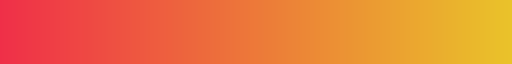

In [8]:
cmap = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#F60002-000000-4DFF00
    (0.000, (0.965, 0.000, 0.008)),
    (0.500, (0.000, 0.000, 0.000)),
    (1.000, (0.302, 1.000, 0.000))))
cmap = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#F60002-000000-4DFF00
    (0.000, (0.941, 0.188, 0.286)), #0.941, 0.188, 0.286
    (1.000, (0.918, 0.765, 0.165))))
cmap

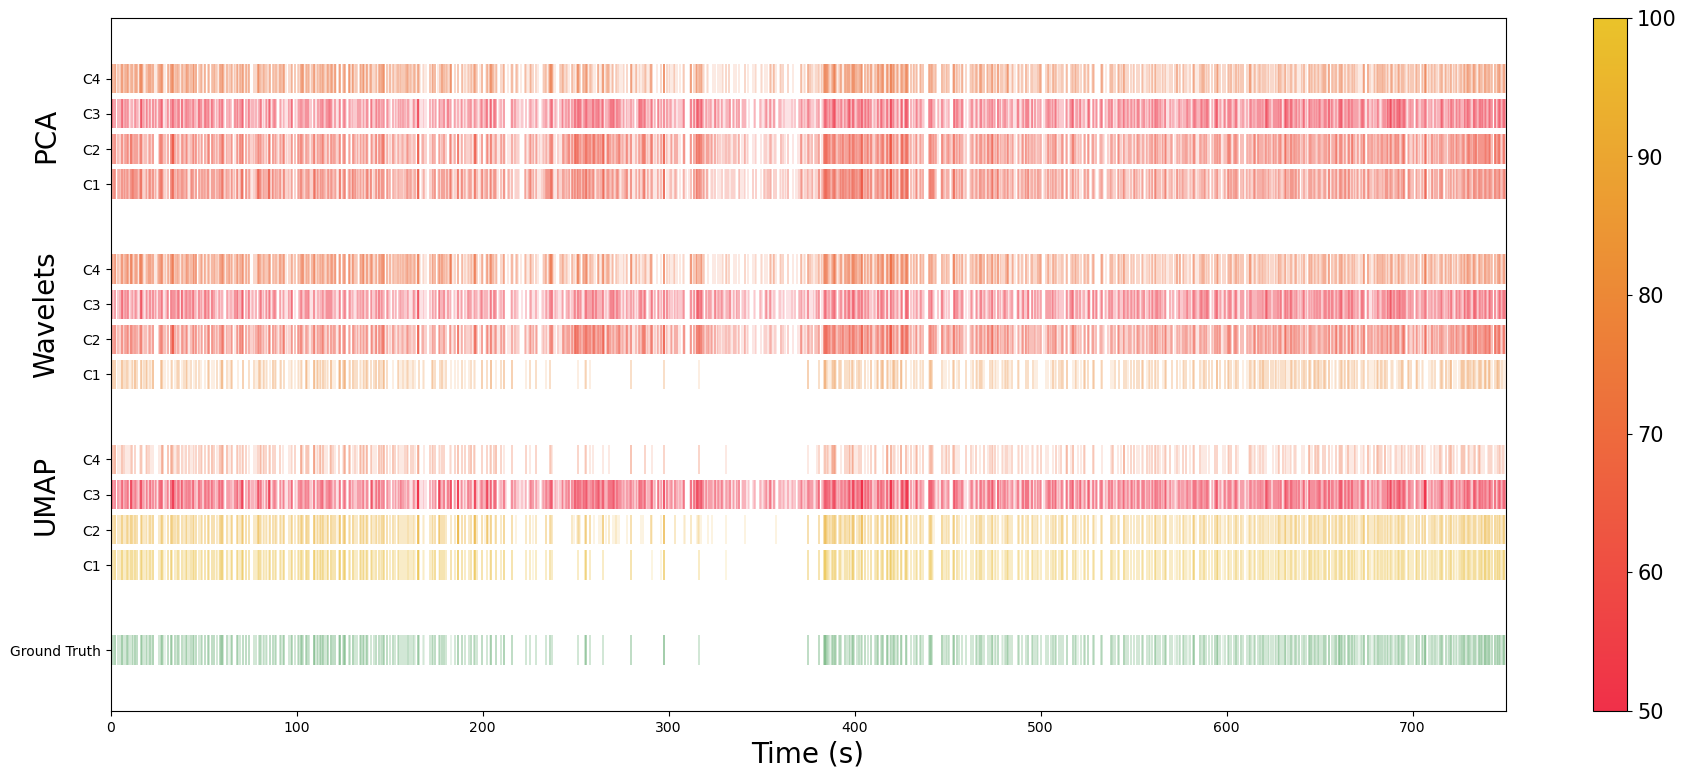

In [9]:
scaler = 1.5
sr = 20000
fig, ax = plt.subplots(figsize=(15 * scaler, 6 * scaler))
for k, m in enumerate(["", "wave_", "pca_"]):
    for j, i in enumerate(keys):
        cluster = data[i][m + "score"][3]
        events = data[i]["pks"][cluster ==  data[i][m + "labs"]]
        f1_score = data[i][m + "score"][0]
        ax.eventplot(events / sr, lineoffsets=j * 1.2 + k * 6.5, linewidths=0.2, color=cmap((f1_score - 50 ) / 50))
ax.eventplot(data["gt_stimes"] / sr, lineoffsets= -2.9, linewidths=0.2, color="#57A767")

#ax.set_title("Ground Truth Intracellular vs most similar clusters for each channel (Buszaki)", size=20)
ax.set_yticks([-2.9] + [j * 1.2 + k * 6.5 for k in range(3) for j in range(4)])
tick_labs = ["Ground Truth"] + list(np.tile(["C1", "C2", "C3", "C4"], 3))
ax.set_yticklabels(tick_labs)
ax.set_xlabel("Time (s)", size=20)
ax.set_xlim(0, 750)

fig.text(0.09, 0.35, 'UMAP', va='center', rotation='vertical', size=20)
fig.text(0.09, 0.55, 'Wavelets', va='center', rotation='vertical', size=20)
fig.text(0.09, 0.75, 'PCA', va='center', rotation='vertical', size=20)

norm = Normalize(vmin=50, vmax=100)
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical')
#cbar.set_label('F1 Score', size=20)
cbar.ax.tick_params(labelsize=15)

#plt.savefig("f1.svg")
plt.show()

In [10]:
#@jit()
def n_dist(st1, st2, w=90): 
    #st1 y st2 son arrays de los tiempos de espigas del cluster con las mejores estadísticas del mismo o diferentes electrodos.
    
    j = 0
    nab = 0
    for i in range(st1.shape[0]): #Por cada tiempo de espiga del primer cluster...
        while j < st2.shape[0]: #Mientras j sea menor que el número de tiempos de espiga del segundo cluster... 
            if (abs(st1[i] - st2[j]) < w):
                #print(st1[i] - st2[j] < w)
                #print(w)
                nab += 1
                break
            elif st2[j] > st1[i]:
                break
            else:
                j += 1
    return nab
        

In [11]:
corr_mats = np.zeros((3, 4, 4))
for k, m in enumerate(["", "wave_", "pca_"]):
    for j, i in enumerate(keys):
        for p in range(j, 4):
            cluster1 = data[i][m + "score"][3] #El cluster con las mejores estadísticas
            events1 = data[i]["pks"][cluster1 ==  data[i][m + "labs"]] #Tiempos de espigas del cluster con las mejores estadísticas
            
            cluster2 = data[keys[p]][m + "score"][3] #Mejor cluster del mismo u otro electrodo
            events2 = data[keys[p]]["pks"][cluster2 ==  data[keys[p]][m + "labs"]] #Tiempos de espigas del mejor cluster del mismo u otro electrodo
            
            n_inters = n_dist(events1, events2)
            corr_mats[k, j, p] = n_inters / len(events1) #len(events1) es el número de espigas del mejor cluster
            corr_mats[k, p, j] = n_inters / len(events2)
            #print(f"{i}    {keys[p]}")

In [12]:
def corr_plotter(corr_mat, title, ax, cmap, vmin=0.2, vmax=1):
    im = ax.imshow(corr_mat, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, size=30)
    ax.set_xticks(np.arange(4)); ax.set_yticks(np.arange(4))
    ax.set_yticklabels([f"C{i + 1}" for i in range(4)], size=25)
    ax.set_xticklabels([f"C{i + 1}" for i in range(4)], size=25)
    return im

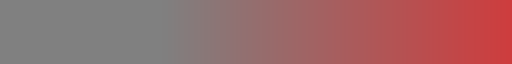

In [13]:
cmap2 = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#31.7:808080-100:CE3D3E
    (0.000, (0.502, 0.502, 0.502)),
    (0.317, (0.502, 0.502, 0.502)),
    (1.000, (0.808, 0.239, 0.243))))
cmap2

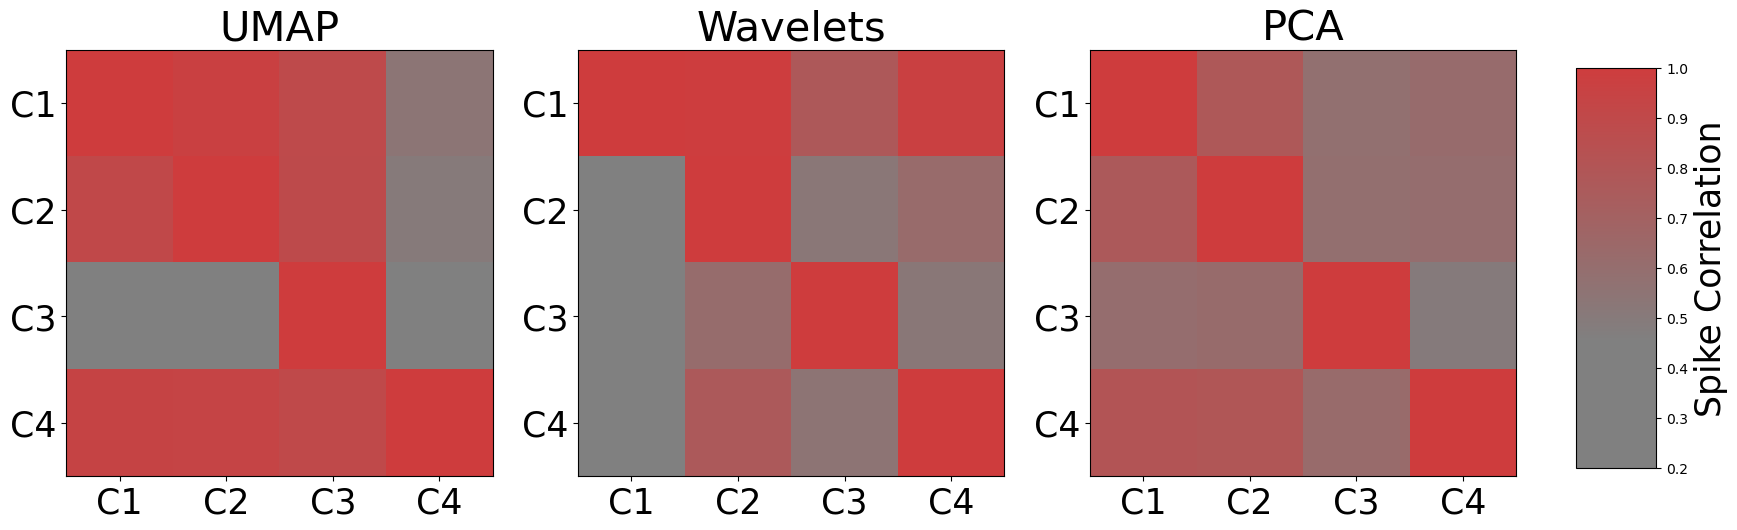

In [14]:
methods = ["UMAP", "Wavelets", "PCA"]

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for i in range(3):
    im = corr_plotter(corr_mats[i], methods[i], axs[i], cmap2)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.29, 0.04, 0.4])    
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Spike Correlation', size=25)
plt.savefig("corr.svg")

In [15]:
electrodo = 1
wave_labs = data[electrodo]["wave_labs"]
wave_emb = data[electrodo]["wave"]
pca_labs = data[electrodo]["pca_labs"]
pca_emb = data[electrodo]["pca"]
gt_labs = data[electrodo]["gt_labs"]
umap_labs = data[electrodo]["labs"]
umap_emb = data[electrodo]["emb"]
spikes_aligned = data[electrodo]["shapes"]


In [16]:
pal_UMAP = ["#E7B800", "#FC4E07", "#005ab3ff", "gray"]
col_UMAP = np.array([pal_UMAP[i] for i in umap_labs])
pal_PCA = ["#FC4E07", "#E7B800", "gray"]
col_PCA = np.array([pal_PCA[i] for i in pca_labs])
pal_wave = ["#FC4E07", "#005ab3ff", "#E7B800", "blueviolet", "green", "gray"]
col_wave = np.array([pal_wave[i] for i in wave_labs])

In [17]:
umap_mod = np.copy(umap_labs)
idxs=np.where(gt_labs==1)[0]
umap_mod[idxs] = 4 
idxs_0 = np.where(umap_mod==0)[0]
umap_mod[idxs_0] = 2
umap_mod[idxs] = 0 

In [18]:
col_mod = np.array([pal_UMAP[i] for i in umap_mod])

In [19]:
pal = ["gray", "#E7B800"]
col_vec = np.array([pal[i] for i in gt_labs])

In [20]:
pal_curves = ["#E7B800", "#FC4E07", "#005ab3ff", "gray"]

In [21]:
s_kwargs = {'marker':'s', "rasterized":False, "facecolors":'none', 's':500, 'linewidth':3}
tri_kwargs = { 'marker':'^', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
ci_kwargs = {'marker':'o', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
x_kwargs = {'marker':'x', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':4}

In [22]:
s_kwargs = {'marker':'s', "rasterized":False, "facecolors":'none', 's':500, 'linewidth':3}
tri_kwargs = { 'marker':'^', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
ci_kwargs = {'marker':'o', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
st_kwargs = {'marker':'*', "rasterized":False, "facecolors":'none', 's':800, 'linewidth':3}
itri_kwargs = {'marker':'v', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
d_kwargs = {'marker':'D', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}

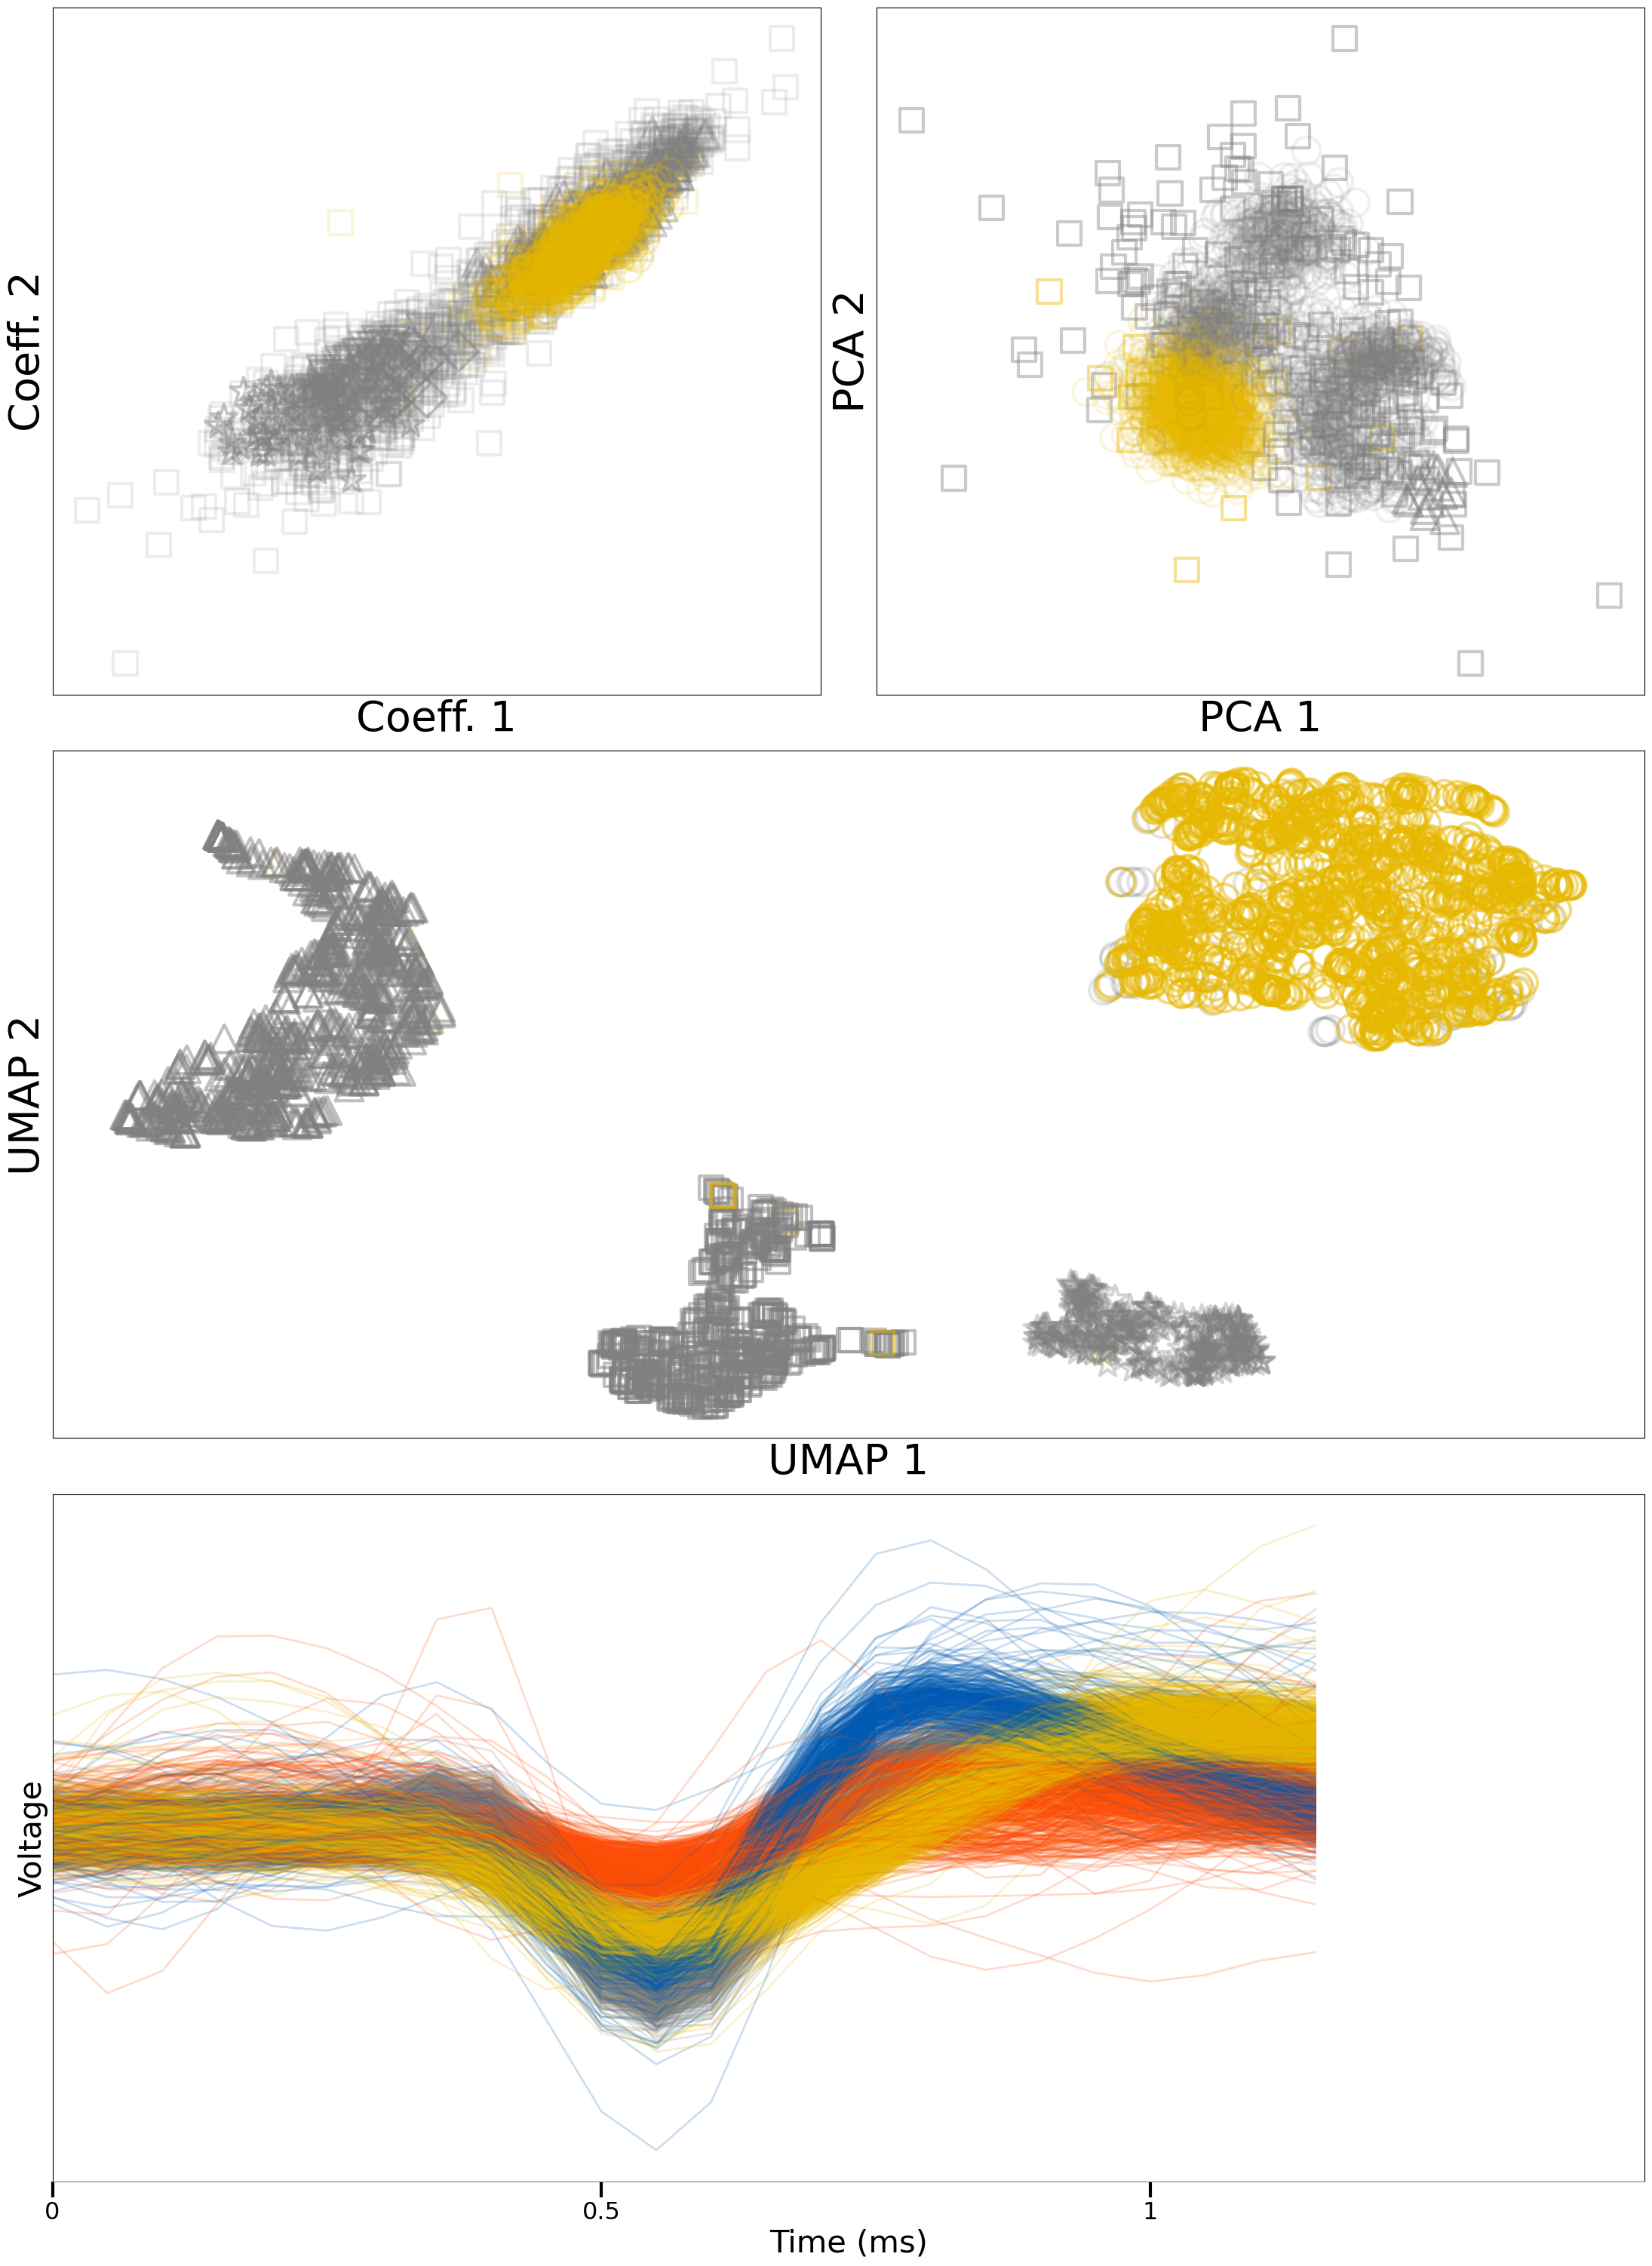

In [23]:
fig = plt.figure(figsize=(22, 40))
gs = gridspec.GridSpec(4, 2)

s_kwargs = {'marker':'s', "rasterized":False, "facecolors":'none', 's':500, 'linewidth':3}
tri_kwargs = { 'marker':'^', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
ci_kwargs = {'marker':'o', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
st_kwargs = {'marker':'*', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
itri_kwargs = {'marker':'v', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
d_kwargs = {'marker':'D', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}

# # -----------------WAVELETS
a_vec = a_labs(wave_labs)

#2D
ax3 = fig.add_subplot(4, 2, 3)
ax3.scatter(*dims(wave_emb, wave_labs == -1, d=2), edgecolors=col_vec[wave_labs==-1], **s_kwargs, alpha=a_vec[0])
ax3.scatter(*dims(wave_emb, wave_labs == 0, d=2), edgecolors=col_vec[wave_labs==0], **st_kwargs, alpha=a_vec[1])
ax3.scatter(*dims(wave_emb, wave_labs == 1, d=2), edgecolors=col_vec[wave_labs==1], **tri_kwargs, alpha=a_vec[2])
ax3.scatter(*dims(wave_emb, wave_labs == 2, d=2), edgecolors=col_vec[wave_labs==2], **ci_kwargs, alpha=a_vec[3])
ax3.scatter(*dims(wave_emb, wave_labs == 3, d=2), edgecolors=col_vec[wave_labs==3], **itri_kwargs, alpha=a_vec[4])
ax3.scatter(*dims(wave_emb, wave_labs == 4, d=2), edgecolors=col_vec[wave_labs==4], **d_kwargs, alpha=a_vec[5])
ax3.set_ylabel("Coeff. 2", size=40); ax3.set_xlabel("Coeff. 1", size=40)
ax3.set_xticks([]); ax3.set_yticks([])


# # ----------------------PCA
a_vec = a_labs(pca_labs)
# 2D
ax4 = fig.add_subplot(4, 2, 4)

ax4.scatter(*dims(pca_emb, pca_labs == -1, d=2), edgecolors=col_vec[pca_labs==-1], **s_kwargs, alpha=a_vec[0])
ax4.scatter(*dims(pca_emb, pca_labs == 0, d=2), edgecolors=col_vec[pca_labs==0], **tri_kwargs, alpha=a_vec[1])
ax4.scatter(*dims(pca_emb, pca_labs == 1, d=2), edgecolors=col_vec[pca_labs==1], **ci_kwargs, alpha=a_vec[2])
ax4.set_ylabel("PCA 2", size=40); ax4.set_xlabel("PCA 1", size=40)
ax4.set_xticks([]); ax4.set_yticks([])

#-------------- UMAP PLOT---------------------
ax6 = fig.add_subplot(gs[2, :])
# misclassification mask
umap_mask = umap_labs == gt_labs
a_vec = a_labs(umap_labs)

ax6.scatter(*dims(umap_emb, umap_mask*(umap_labs==0), d=2), edgecolors=col_vec[umap_mask * (umap_labs==0)], **ci_kwargs, alpha=a_vec[1])
ax6.scatter(*dims(umap_emb, umap_mask*(umap_labs==1), d=2), edgecolors=col_vec[umap_mask * (umap_labs==1)], **tri_kwargs, alpha=a_vec[2])
ax6.scatter(*dims(umap_emb, umap_mask*(umap_labs==2), d=2), edgecolors=col_vec[umap_mask * (umap_labs==2)], **s_kwargs, alpha=a_vec[3])
ax6.scatter(*dims(umap_emb, umap_mask*(umap_labs==3), d=2), edgecolors=col_vec[umap_mask * (umap_labs==2)], **st_kwargs, alpha=a_vec[3])


ax6.scatter(*dims(umap_emb, ~umap_mask*(umap_labs == 0), d=2), edgecolors=col_vec[~umap_mask * (umap_labs==0)], **ci_kwargs, alpha=0.5)
ax6.scatter(*dims(umap_emb, ~umap_mask*(umap_labs == 1), d=2), edgecolors=col_vec[~umap_mask * (umap_labs==1)], **tri_kwargs, alpha=0.5)
ax6.scatter(*dims(umap_emb, ~umap_mask*(umap_labs == 2), d=2), edgecolors=col_vec[~umap_mask * (umap_labs==2)], **s_kwargs, alpha=0.5)
ax6.scatter(*dims(umap_emb, ~umap_mask*(umap_labs == 3), d=2), edgecolors=col_vec[~umap_mask * (umap_labs==2)], **st_kwargs, alpha=a_vec[3])

ax6.set_xticks([]); ax6.set_yticks([])
ax6.set_ylabel("UMAP 2", size=40); ax6.set_xlabel("UMAP 1", size=40)
# ---------------- SPIKES --------------------
ax7 = fig.add_subplot(gs[3, :])
for j, i in enumerate(spikes_aligned):
    ax7.plot(i / 10, color=pal_curves[int(umap_labs[j])], alpha=0.2, linewidth=2, rasterized=False)

plt.grid(visible=False)
ax7.set_yticks([])
ax7.set_xlim(0, 29)
ax7.set_xticks([0, 10, 20])
ax7.set_xticklabels([0, 0.5, 1], size=23)

ax7.spines['bottom'].set_color('0.5')
ax7.tick_params('both', length=15, width=3, which='major')
ax7.set_xlabel("Time (ms)", size=30)
ax7.set_ylabel("Voltage", size=30)

plt.tight_layout()
#plt.savefig("fig3.pdf", dpi=400)

In [24]:
pks = data[1]["pks"]
pks_3 = data[3]["pks"]

In [25]:
gt_stimes = data["gt_stimes"]

In [26]:
def get_gt_labs(pks, gt_times, delta=20):
    diff_matrix = cdist(pks[:, None], gt_times[:, None]).astype(int)
    busz_gt_indx = np.where(diff_matrix < delta)[0]
    busz_gt_labs = np.zeros(pks.shape, dtype=int)
    busz_gt_labs[busz_gt_indx] = 1
    return busz_gt_labs, diff_matrix

In [27]:
electrodo = 3
wave_labs_3 = data[electrodo]["wave_labs"]
wave_emb_3 = data[electrodo]["wave"]
pca_labs_3 = data[electrodo]["pca_labs"]
pca_emb_3 = data[electrodo]["pca"]
gt_labs_3 = data[electrodo]["gt_labs"]
umap_labs_3 = data[electrodo]["labs"]
umap_emb_3 = data[electrodo]["emb"]
spikes_aligned_3 = data[electrodo]["shapes"]

In [28]:
elec1_cluster_0 = pks[umap_labs==0]
elec1_cluster_1 = pks[umap_labs==1]
elec1_cluster_2 = pks[umap_labs==2]
elec1_cluster_3 = pks[umap_labs==3]

In [29]:
cls0, diff0 = get_gt_labs(pks_3, elec1_cluster_0)
cls1, diff1 = get_gt_labs(pks_3, elec1_cluster_1)
cls2, diff2 = get_gt_labs(pks_3, elec1_cluster_2)
cls3, diff3 = get_gt_labs(pks_3, elec1_cluster_3)

In [30]:
idxs0 = np.where(cls0==1)[0]
idxs1 = np.where(cls1==1)[0]
idxs2 = np.where(cls2==1)[0]
idxs3 = np.where(cls3==1)[0]

In [31]:
clusters = [idxs0, idxs1, idxs2, idxs3]

In [32]:
cls1in3 = np.ones(len(pks_3), dtype=np.int32)*-1

In [33]:
for i in range(len(clusters)):
    cls1in3[clusters[i]] = i

In [34]:
pal_curves_3 = ["#E7B800", "#FC4E07", "#005ab3ff", "gray", "blueviolet"]

In [35]:
col_1in3 = np.array([pal_curves_3[i] for i in cls1in3])

In [36]:
np.unique(umap_labs_3)

array([0, 1], dtype=int64)

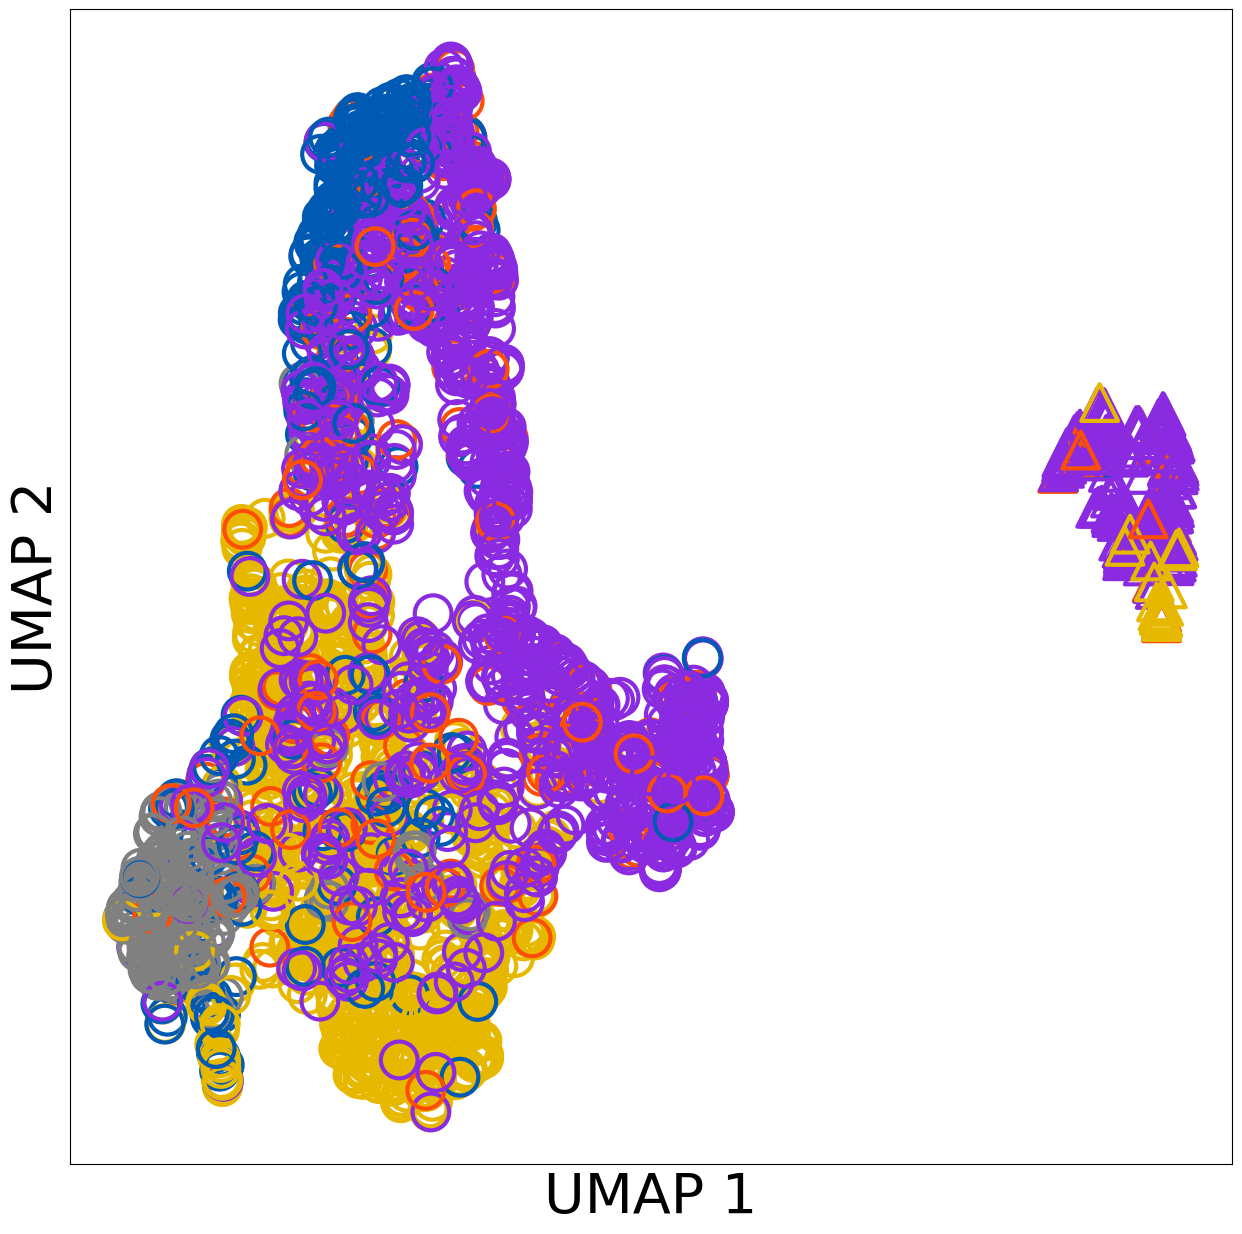

In [37]:
fig = plt.figure(figsize=(15, 15))
#gs = gridspec.GridSpec(4, 2)
#ax6 = fig.add_subplot(gs[2, :])
ax6 = fig.add_subplot(111)

# misclassification mask
umap_mask = umap_labs_3 == gt_labs_3
a_vec = a_labs(umap_labs_3)

ax6.scatter(*dims(umap_emb_3, umap_mask*(umap_labs_3==0), d=2), edgecolors=col_1in3[umap_mask * (umap_labs_3==0)], **tri_kwargs)
ax6.scatter(*dims(umap_emb_3, umap_mask*(umap_labs_3==1), d=2), edgecolors=col_1in3[umap_mask * (umap_labs_3==1)], **ci_kwargs)


ax6.scatter(*dims(umap_emb_3, ~umap_mask*(umap_labs_3 == 0), d=2), edgecolors=col_1in3[~umap_mask * (umap_labs_3==0)], **tri_kwargs)
ax6.scatter(*dims(umap_emb_3, ~umap_mask*(umap_labs_3 == 1), d=2), edgecolors=col_1in3[~umap_mask * (umap_labs_3==1)], **ci_kwargs)

ax6.set_xticks([]); ax6.set_yticks([])
ax6.set_ylabel("UMAP 2", size=40); ax6.set_xlabel("UMAP 1", size=40)
plt.savefig("fig3UMAP_e3.svg", dpi=400)

In [38]:
s_kwargs = {'marker':'s', "rasterized":False, "facecolors":'none', 's':500, 'linewidth':3}
tri_kwargs = { 'marker':'^', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
ci_kwargs = {'marker':'o', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
st_kwargs = {'marker':'*', "rasterized":False, "facecolors":'none', 's':1200, 'linewidth':3}
itri_kwargs = {'marker':'v', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}
d_kwargs = {'marker':'D', "rasterized":False, "facecolors":'none', 's':700, 'linewidth':3}

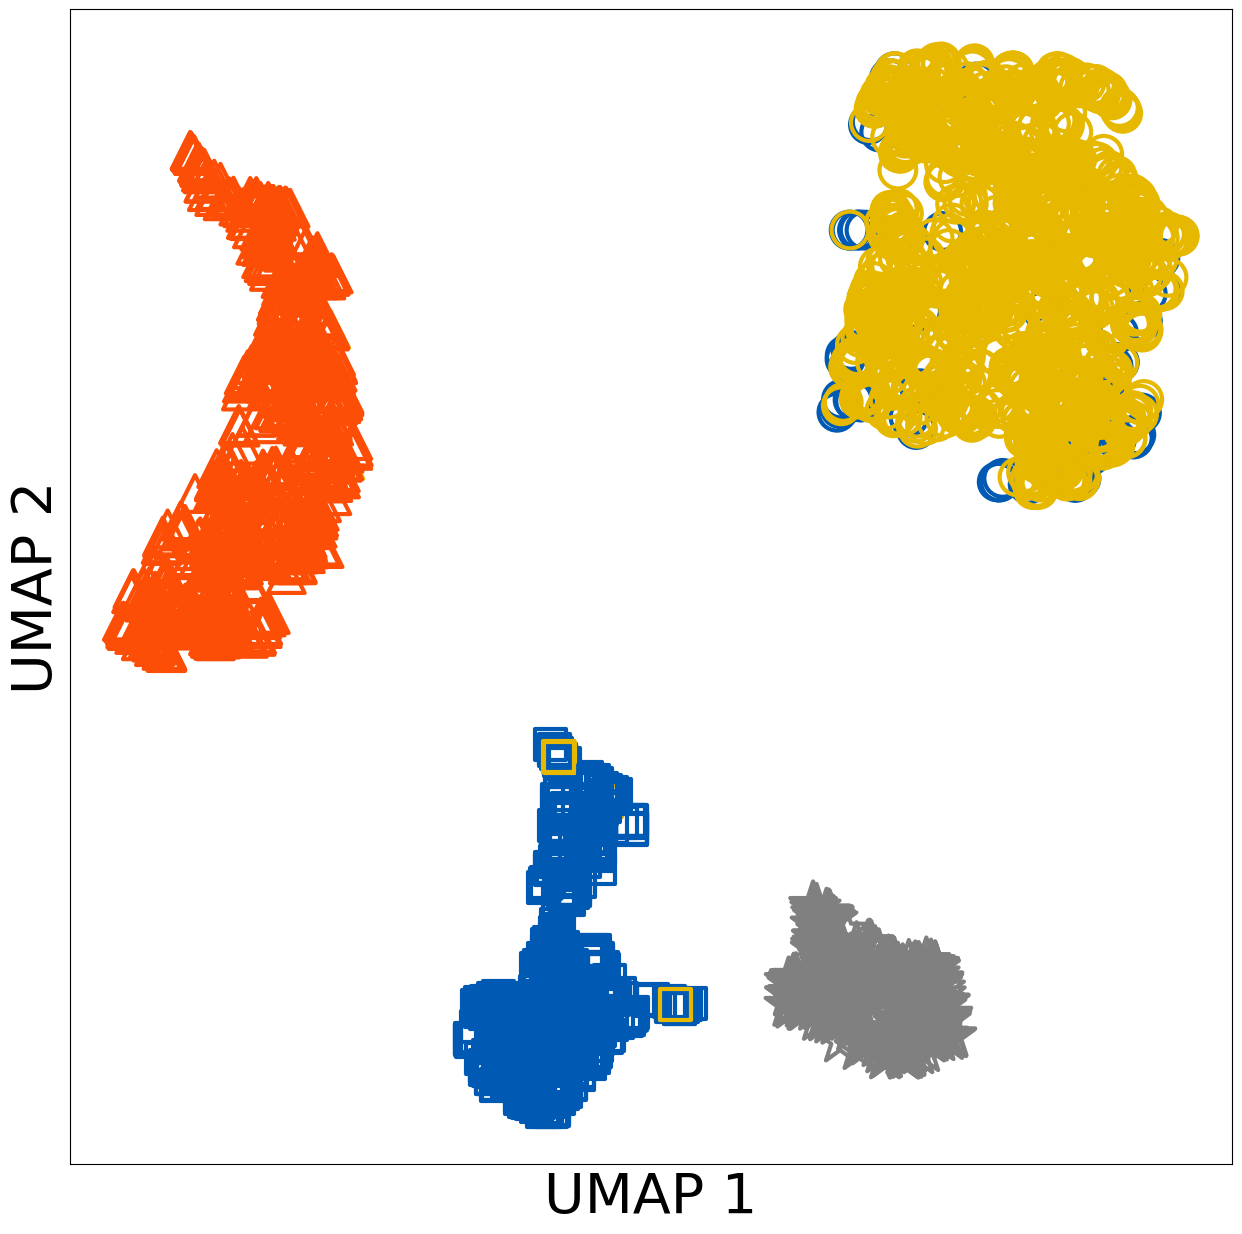

In [39]:
fig = plt.figure(figsize=(15, 15))
#gs = gridspec.GridSpec(4, 2)
#ax6 = fig.add_subplot(gs[2, :])
ax6 = fig.add_subplot(111)

# misclassification mask
umap_mask = umap_labs == gt_labs
a_vec = a_labs(umap_labs)

ax6.scatter(*dims(umap_emb, umap_mask*(umap_labs==0), d=2), edgecolors=col_mod[umap_mask * (umap_labs==0)], **ci_kwargs)
ax6.scatter(*dims(umap_emb, umap_mask*(umap_labs==1), d=2), edgecolors=col_mod[umap_mask * (umap_labs==1)], **tri_kwargs)
ax6.scatter(*dims(umap_emb, umap_mask*(umap_labs==2), d=2), edgecolors=col_mod[umap_mask * (umap_labs==2)], **s_kwargs)
ax6.scatter(*dims(umap_emb, umap_mask*(umap_labs==3), d=2), edgecolors=col_mod[umap_mask * (umap_labs==3)], **st_kwargs)


ax6.scatter(*dims(umap_emb, ~umap_mask*(umap_labs == 0), d=2), edgecolors=col_mod[~umap_mask * (umap_labs==0)], **ci_kwargs)
ax6.scatter(*dims(umap_emb, ~umap_mask*(umap_labs == 1), d=2), edgecolors=col_mod[~umap_mask * (umap_labs==1)], **tri_kwargs)
ax6.scatter(*dims(umap_emb, ~umap_mask*(umap_labs == 2), d=2), edgecolors=col_mod[~umap_mask * (umap_labs==2)], **s_kwargs)
ax6.scatter(*dims(umap_emb, ~umap_mask*(umap_labs == 3), d=2), edgecolors=col_mod[~umap_mask * (umap_labs==3)], **st_kwargs)

ax6.set_xticks([]); ax6.set_yticks([])
ax6.set_ylabel("UMAP 2", size=40); ax6.set_xlabel("UMAP 1", size=40)
plt.savefig("fig3UMAP_UMAPcolors.svg", dpi=400)

In [40]:
pal_curves = ["#E7B800", "#FC4E07", "#005ab3ff", "gray"]

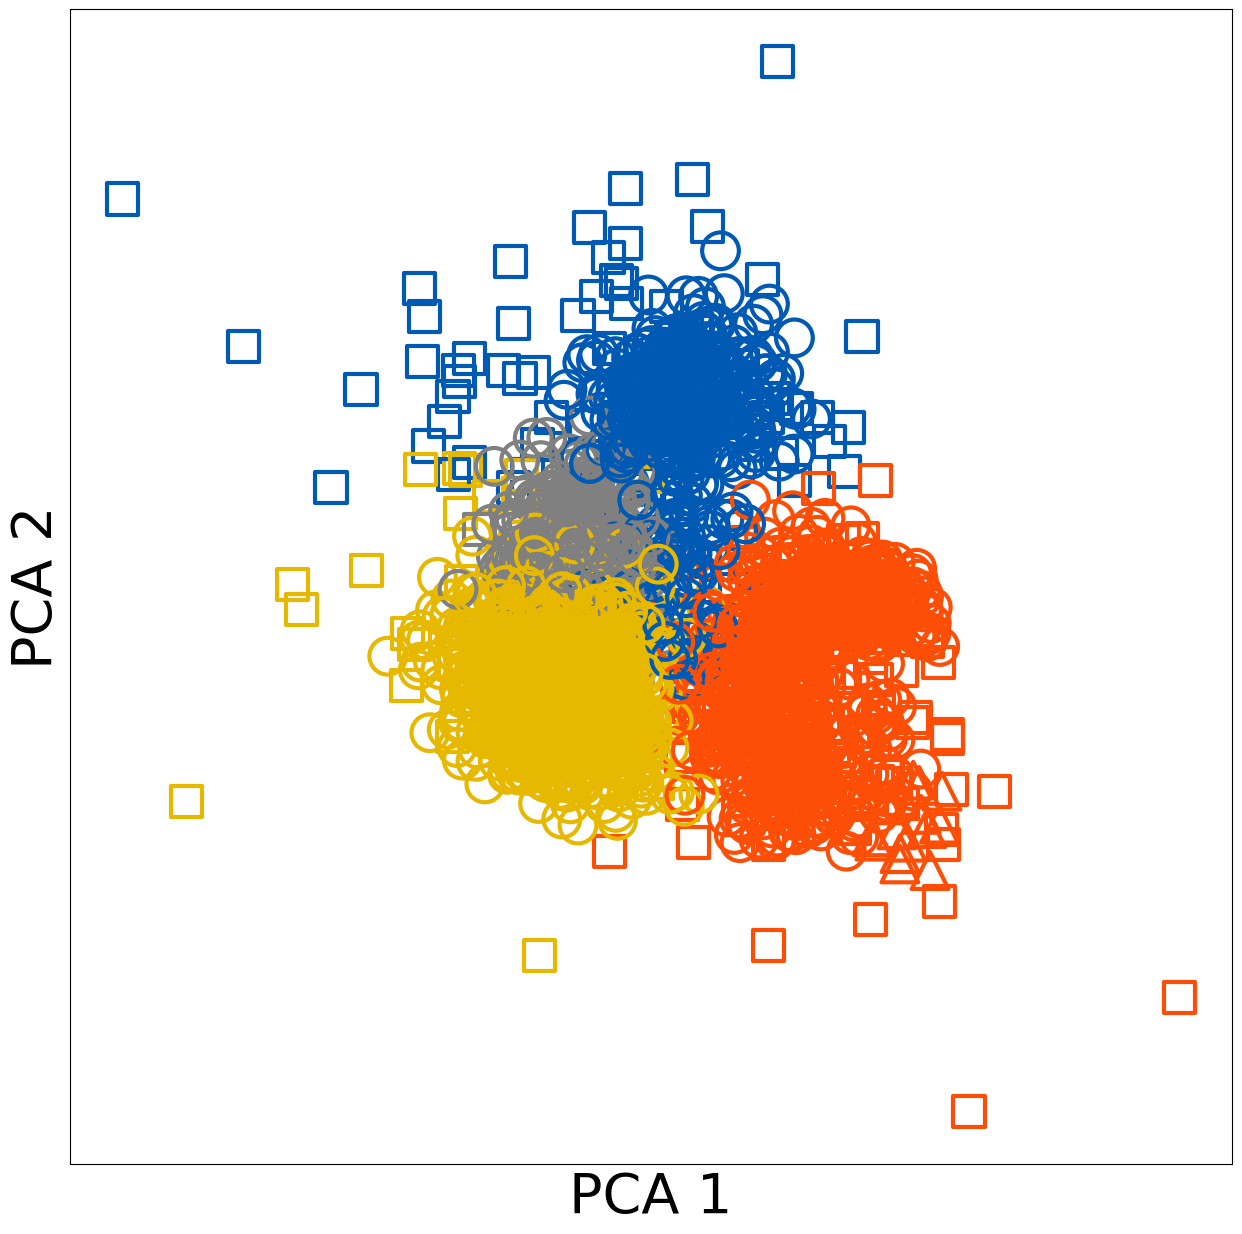

In [41]:
fig = plt.figure(figsize=(15, 15))
a_vec = a_labs(pca_labs)
# 2D
ax4 = fig.add_subplot(111)

ax4.scatter(*dims(pca_emb, pca_labs == -1, d=2), edgecolors=col_UMAP[pca_labs==-1], **s_kwargs)
ax4.scatter(*dims(pca_emb, pca_labs == 0, d=2), edgecolors=col_UMAP[pca_labs==0], **tri_kwargs)
ax4.scatter(*dims(pca_emb, pca_labs == 1, d=2), edgecolors=col_UMAP[pca_labs==1], **ci_kwargs)
ax4.set_ylabel("PCA 2", size=40); ax4.set_xlabel("PCA 1", size=40)
ax4.set_xticks([]); ax4.set_yticks([])
plt.savefig("fig3PCA_UMAPcolors.svg", dpi=400)

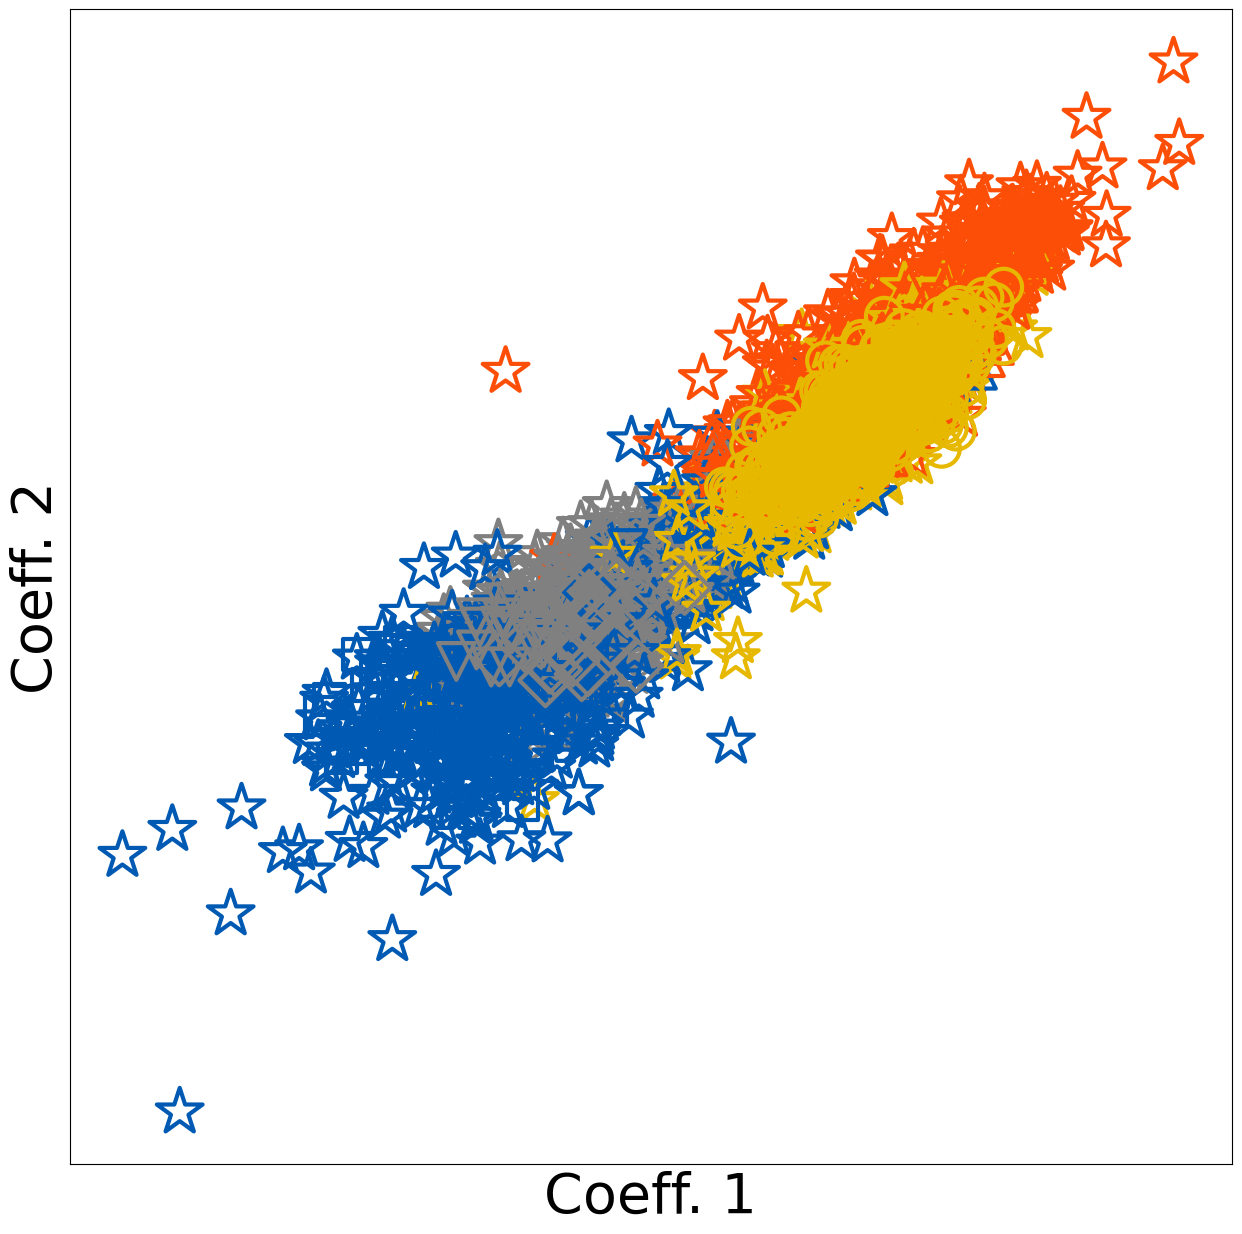

In [42]:
fig = plt.figure(figsize=(15, 15))
a_vec = a_labs(wave_labs)

#2D
ax3 = fig.add_subplot(111)
ax3.scatter(*dims(wave_emb, wave_labs == -1, d=2), edgecolors=col_UMAP[wave_labs==-1], **st_kwargs)
ax3.scatter(*dims(wave_emb, wave_labs == 0, d=2), edgecolors=col_UMAP[wave_labs==0], **s_kwargs)
ax3.scatter(*dims(wave_emb, wave_labs == 1, d=2), edgecolors=col_UMAP[wave_labs==1], **tri_kwargs)
ax3.scatter(*dims(wave_emb, wave_labs == 2, d=2), edgecolors=col_UMAP[wave_labs==2], **ci_kwargs)
ax3.scatter(*dims(wave_emb, wave_labs == 3, d=2), edgecolors=col_UMAP[wave_labs==3], **itri_kwargs)
ax3.scatter(*dims(wave_emb, wave_labs == 4, d=2), edgecolors=col_UMAP[wave_labs==4], **d_kwargs)
ax3.set_ylabel("Coeff. 2", size=40); ax3.set_xlabel("Coeff. 1", size=40)
ax3.set_xticks([]); ax3.set_yticks([])
plt.savefig("fig3wavelets_UMAPcolors.svg", dpi=400)

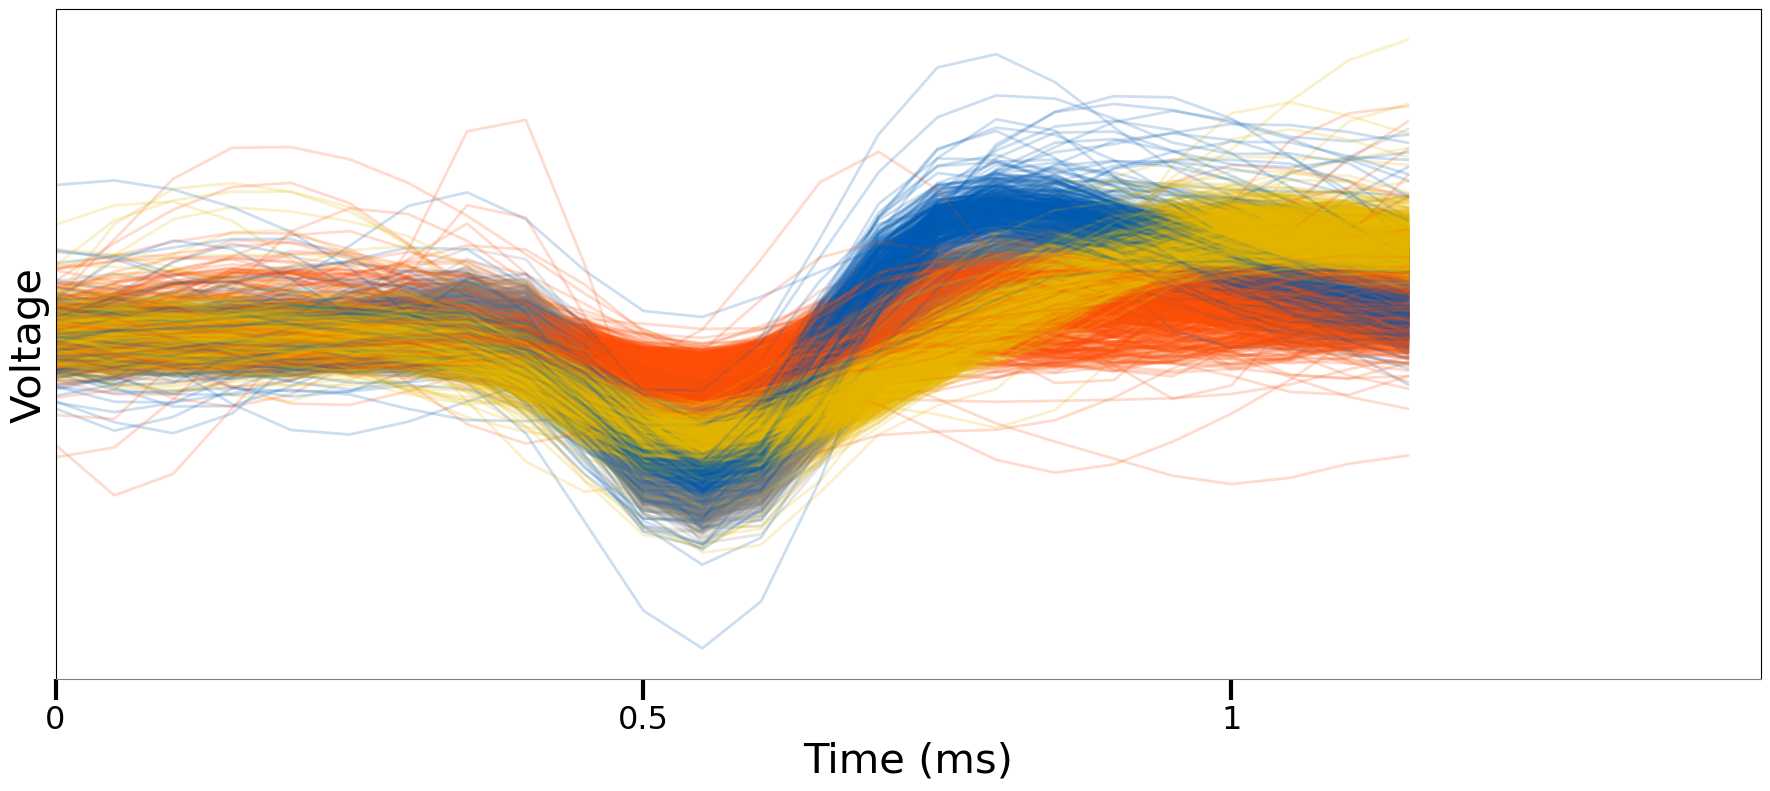

In [43]:
fig = plt.figure(figsize=(22, 40))
gs = gridspec.GridSpec(4, 2)
ax7 = fig.add_subplot(gs[3, :])
for j, i in enumerate(spikes_aligned):
     ax7.plot(i / 10, color=pal_curves[int(umap_labs[j])], alpha=0.2, linewidth=2, rasterized=False)

#plt.grid(visible=True)
ax7.set_yticks([])
ax7.set_xlim(0, 29)
ax7.set_xticks([0, 10, 20])
ax7.set_xticklabels([0, 0.5, 1], size=23)

ax7.spines['bottom'].set_color('0.5')
ax7.tick_params('both', length=15, width=3, which='major')
ax7.set_xlabel("Time (ms)", size=30)
ax7.set_ylabel("Voltage", size=30)
plt.savefig("fig3_espigas.svg")